In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


In [ ]:
# Load the dataset
df = pd.read_csv('fraud_detection_data.csv')


In [ ]:
# Display basic information and first few rows
print(df.head())
df.info()
print(df.describe())

                         Transaction ID                           Customer ID  \
0  90023589-2ef8-43e7-807a-b4ab92fcc2a4  5d7358c2-ede9-488a-96e4-fa78a9d9d6db   
1  3eb2e762-9525-4c33-a022-a47e3da3ec5d  0aac2ab4-f920-428a-939a-78ff9858c13d   
2  12d58e99-92d7-46f3-8ac0-e01ac86c15ec  4d6ee059-5df1-4323-8484-2f04aae3d6b3   
3  e9cac917-d336-4629-9baa-f8c19691cb80  d7709d08-fa3c-419c-b2fb-bc9ef2997ef9   
4  acb39efa-d3c7-4bae-9b6c-9cda5ed79503  e505e3e6-7982-4c7f-b0b1-26a0b6d59d31   

      Transaction Date  Transaction Amount                  Merchant  \
0  2024-03-05 15:53:49              231.55            Torres-Sanchez   
1  2024-07-04 01:00:25             1485.69   Brandt, Ross and Butler   
2  2024-01-14 00:18:53              497.33               Delgado LLC   
3  2023-12-09 03:06:54              287.68  Smith, Mcdonald and Cruz   
4  2024-02-17 03:22:55              213.97                  Huff Ltd   

           Location   Transaction Type   Card Type Is Fraudulent  
0         Wes

In [ ]:
print(df.isnull().sum())

Transaction ID        0
Customer ID           0
Transaction Date      0
Transaction Amount    0
Merchant              0
Location              0
Transaction Type      0
Card Type             0
Is Fraudulent         0
dtype: int64


Is Fraudulent
Yes    183
No     180
Name: count, dtype: int64


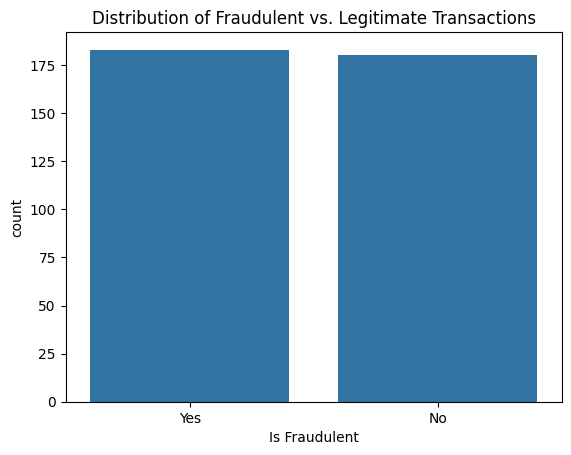

In [ ]:
# Checking the distribution of the 'Is Fraudulent' column
print(df['Is Fraudulent'].value_counts())
sns.countplot(x='Is Fraudulent', data=df)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.show()

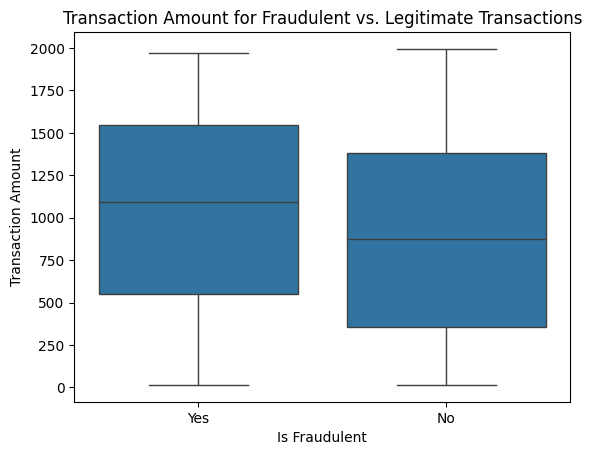

In [ ]:
# Visualizing transaction amount for fraudulent vs. legitimate transactions
sns.boxplot(x='Is Fraudulent', y='Transaction Amount', data=df)
plt.title('Transaction Amount for Fraudulent vs. Legitimate Transactions')
plt.show()

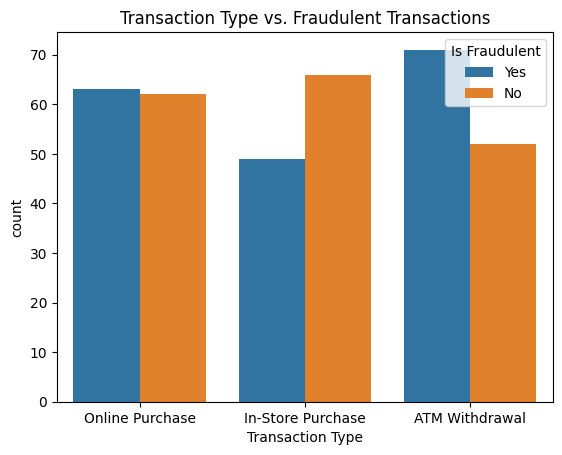

In [ ]:
# Countplot for Transaction Type vs. Fraudulent Transactions
sns.countplot(x='Transaction Type', hue='Is Fraudulent', data=df)
plt.title('Transaction Type vs. Fraudulent Transactions')
plt.show()

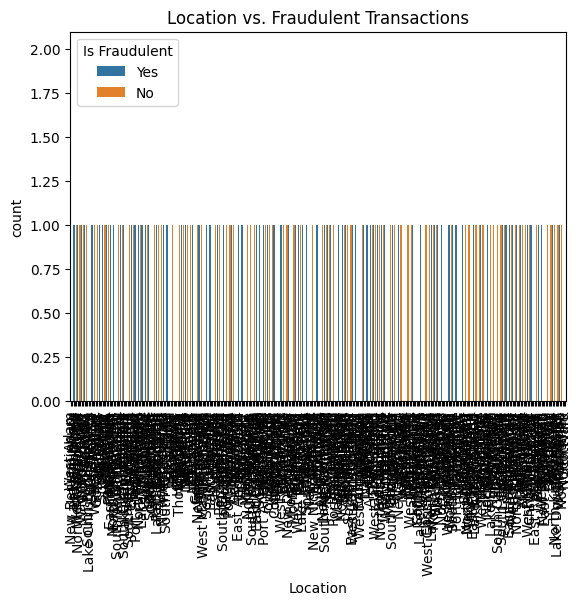

In [ ]:
# Countplot for Location vs. Fraudulent Transactions
sns.countplot(x='Location', hue='Is Fraudulent', data=df)
plt.title('Location vs. Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

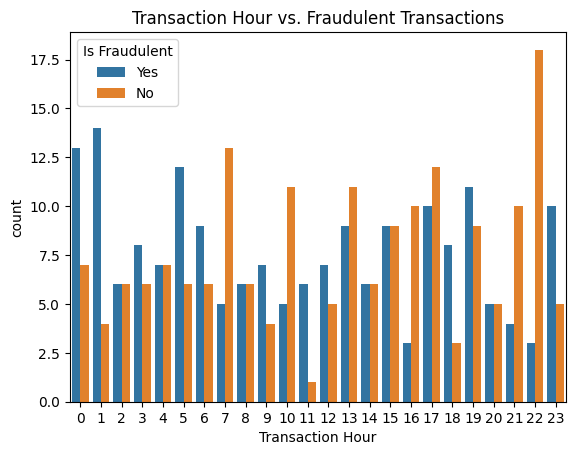

In [ ]:
# Convert 'Transaction Date' to datetime and extract the hour
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Transaction Hour'] = df['Transaction Date'].dt.hour
sns.countplot(x='Transaction Hour', hue='Is Fraudulent', data=df)
plt.title('Transaction Hour vs. Fraudulent Transactions')
plt.show()

In [ ]:
# One-Hot Encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['Merchant', 'Location', 'Transaction Type', 'Card Type'], drop_first=True)

In [ ]:
le = LabelEncoder()
df_encoded['Is Fraudulent'] = le.fit_transform(df_encoded['Is Fraudulent'])

In [ ]:
# Additional Feature Engineering
df_encoded['Transaction Count'] = df_encoded.groupby('Customer ID')['Customer ID'].transform('count')
df_encoded['Avg Transaction Amount'] = df_encoded.groupby('Customer ID')['Transaction Amount'].transform('mean')
df_encoded['Total Transaction Amount'] = df_encoded.groupby('Customer ID')['Transaction Amount'].transform('sum')
df_encoded['Median Transaction Amount'] = df_encoded.groupby('Customer ID')['Transaction Amount'].transform('median')

In [ ]:
# Create a categorical feature for time of day
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [ ]:
df_encoded['Time of Day'] = df_encoded['Transaction Hour'].apply(get_time_of_day)

In [ ]:
# Calculate the recency of each transaction
most_recent_date = df_encoded.groupby('Customer ID')['Transaction Date'].transform('max')
df_encoded['Transaction Recency'] = (most_recent_date - df_encoded['Transaction Date']).dt.days
print(df_encoded.head())
print(df_encoded['Is Fraudulent'].value_counts())
print(df_encoded[['Transaction Count', 'Avg Transaction Amount', 'Total Transaction Amount', 'Median Transaction Amount']].head())


                         Transaction ID                           Customer ID  \
0  90023589-2ef8-43e7-807a-b4ab92fcc2a4  5d7358c2-ede9-488a-96e4-fa78a9d9d6db   
1  3eb2e762-9525-4c33-a022-a47e3da3ec5d  0aac2ab4-f920-428a-939a-78ff9858c13d   
2  12d58e99-92d7-46f3-8ac0-e01ac86c15ec  4d6ee059-5df1-4323-8484-2f04aae3d6b3   
3  e9cac917-d336-4629-9baa-f8c19691cb80  d7709d08-fa3c-419c-b2fb-bc9ef2997ef9   
4  acb39efa-d3c7-4bae-9b6c-9cda5ed79503  e505e3e6-7982-4c7f-b0b1-26a0b6d59d31   

     Transaction Date  Transaction Amount  Is Fraudulent  Transaction Hour  \
0 2024-03-05 15:53:49              231.55              1                15   
1 2024-07-04 01:00:25             1485.69              1                 1   
2 2024-01-14 00:18:53              497.33              1                 0   
3 2023-12-09 03:06:54              287.68              1                 3   
4 2024-02-17 03:22:55              213.97              0                 3   

   Merchant_Adams-Gutierrez  Merchant_Adkins

In [ ]:
# Drop non-numeric columns and prepare for model
X = df_encoded.drop(columns=['Is Fraudulent', 'Transaction ID', 'Customer ID', 'Transaction Date'])
y = df_encoded['Is Fraudulent']
print(X.head())
print(y.head())


   Transaction Amount  Transaction Hour  Merchant_Adams-Gutierrez  \
0              231.55                15                     False   
1             1485.69                 1                     False   
2              497.33                 0                     False   
3              287.68                 3                     False   
4              213.97                 3                     False   

   Merchant_Adkins, Figueroa and Parker  Merchant_Allen Ltd  \
0                                 False               False   
1                                 False               False   
2                                 False               False   
3                                 False               False   
4                                 False               False   

   Merchant_Allen, Dean and Cortez  Merchant_Anderson Group  \
0                            False                    False   
1                            False                    False   
2                

In [ ]:
# One-Hot Encoding for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)
print(X_encoded.head())


   Transaction Amount  Transaction Hour  Merchant_Adams-Gutierrez  \
0              231.55                15                     False   
1             1485.69                 1                     False   
2              497.33                 0                     False   
3              287.68                 3                     False   
4              213.97                 3                     False   

   Merchant_Adkins, Figueroa and Parker  Merchant_Allen Ltd  \
0                                 False               False   
1                                 False               False   
2                                 False               False   
3                                 False               False   
4                                 False               False   

   Merchant_Allen, Dean and Cortez  Merchant_Anderson Group  \
0                            False                    False   
1                            False                    False   
2                

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (254, 729)
Testing set shape: (109, 729)


In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Original training set distribution:")
print(y_train.value_counts())
print("Resampled training set distribution:")
print(pd.Series(y_train_resampled).value_counts())


Original training set distribution:
Is Fraudulent
1    128
0    126
Name: count, dtype: int64
Resampled training set distribution:
Is Fraudulent
0    128
1    128
Name: count, dtype: int64


In [ ]:
# Check the new distribution
print("Original training set distribution:")
print(y_train.value_counts())
print("Resampled training set distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original training set distribution:
Is Fraudulent
1    128
0    126
Name: count, dtype: int64
Resampled training set distribution:
Is Fraudulent
0    128
1    128
Name: count, dtype: int64


In [ ]:
# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Get feature importances
importances = model.feature_importances_
features = X_train_resampled.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

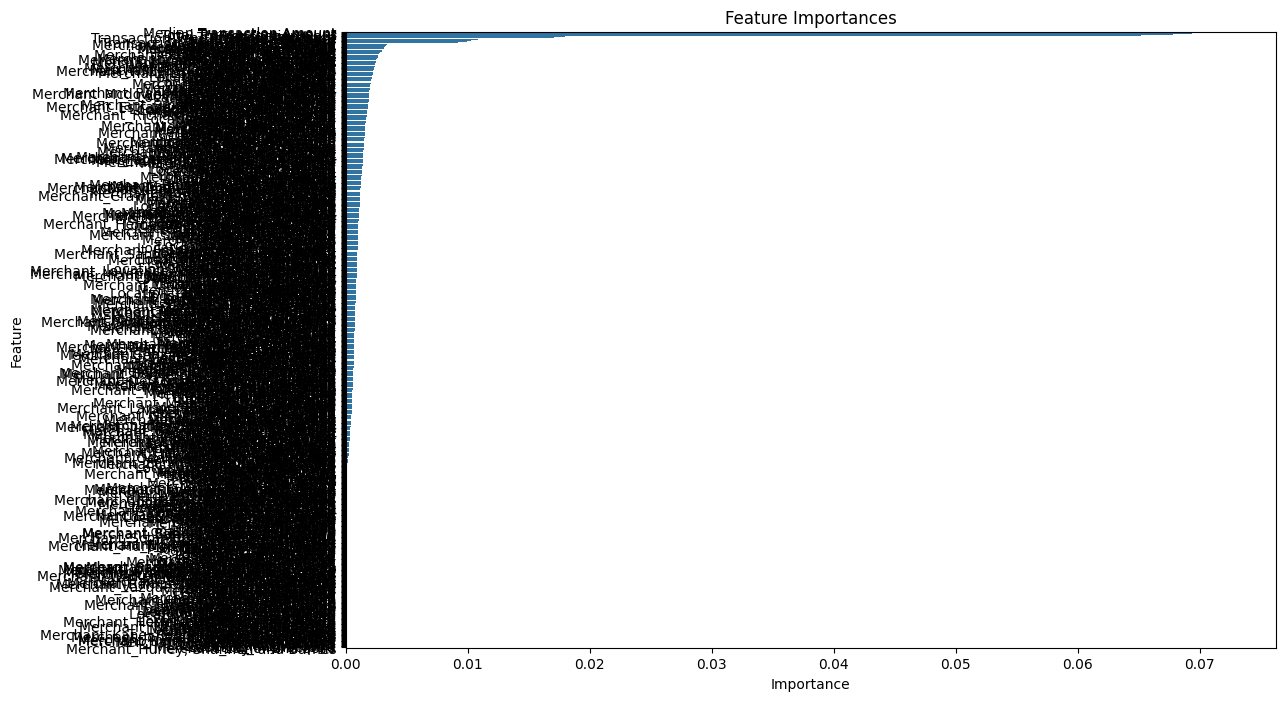

In [ ]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [ ]:
# Example of interaction feature and scatter plot
X_encoded['Amount_Hour_Interaction'] = X_encoded['Transaction Amount'] * X_encoded['Transaction Hour']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

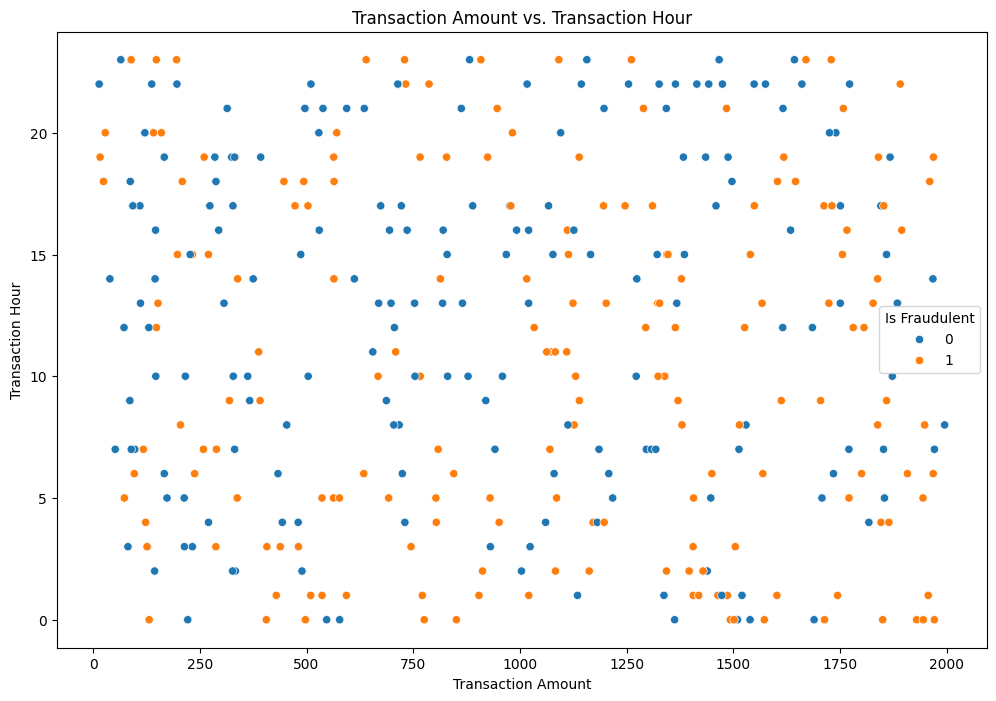

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Transaction Amount', y='Transaction Hour', hue='Is Fraudulent', data=df_encoded)
plt.title('Transaction Amount vs. Transaction Hour')
plt.show()

In [ ]:
# Feature Selection with RFE
model_lr = LogisticRegression(max_iter=1000)
selector = RFE(model_lr, n_features_to_select=10)
selector.fit(X_train_resampled, y_train_resampled)


RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)

In [ ]:
# Get selected features
selected_features = X_train_resampled.columns[selector.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Merchant_Foster, Phillips and Daniel', 'Merchant_Poole-Smith',
       'Merchant_Randolph, Castillo and White', 'Location_East Christina',
       'Location_North Christopher', 'Location_North Michael',
       'Location_Ronaldburgh', 'Location_Valerieville',
       'Location_West Connieport', 'Time of Day_Evening'],
      dtype='object')


In [ ]:
# Train Logistic Regression model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_lr = model_lr.predict(X_test)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_gb = model_gb.predict(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best Parameters:", grid_search_rf.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


Accuracy: 0.5412844036697247
Precision: 0.5609756097560976
Recall: 0.41818181818181815
F1 Score: 0.47916666666666663
AUC-ROC: 0.5424242424242425
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        54
           1       0.56      0.42      0.48        55

    accuracy                           0.54       109
   macro avg       0.55      0.54      0.53       109
weighted avg       0.55      0.54      0.53       109



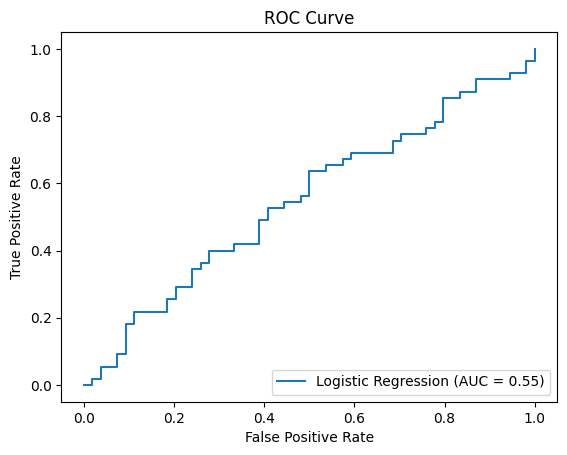

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
auc_roc = roc_auc_score(y_test, y_pred_lr)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Classification report
print(classification_report(y_test, y_pred_lr))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model_lr.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
